
# Stacked Regressions to predict House Prices

In [2]:
# importing the necessary files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # Return a list of colors defining a color palette
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm,skew


In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
# Id coloumn is unecessary for prediction so we drop it
print('shape of train data before droping ID {}'.format(train.shape))
print('shape of test data before droping ID {}'.format(test.shape))

train.drop('Id',axis=1,inplace=True)
test_id=test['Id']
test.drop('Id',axis=1,inplace=True)

print('\n')
print('shape of train data after droping ID {}'.format(train.shape))
print('shape of test data after droping ID {}'.format(test.shape))

shape of train data before droping ID (1460, 81)
shape of test data before droping ID (1459, 80)


shape of train data after droping ID (1460, 80)
shape of test data after droping ID (1459, 79)


# DATA PREPROCESSING 

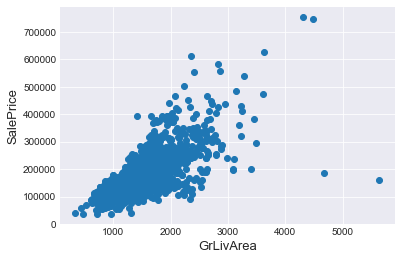

In [8]:
#outilers

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

In [9]:
train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index

Int64Index([523, 1298], dtype='int64')

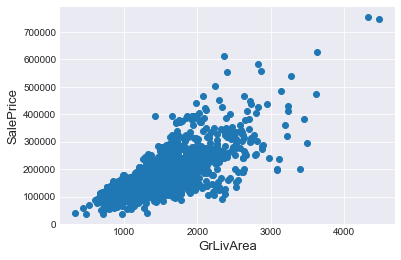

In [10]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Target Variable


 mu 180932.92 and sigma 79467.79 is 


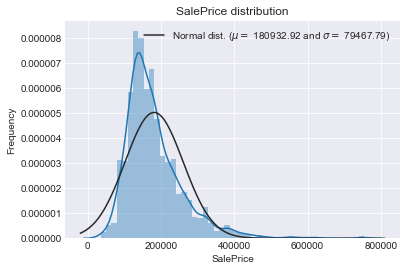

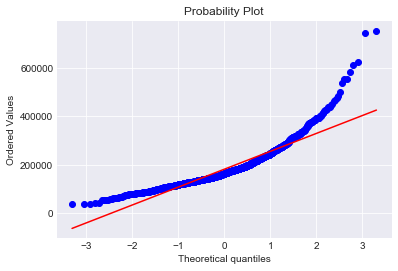

In [11]:
# SalesPrice is the variable we need to predict.Let's explore it 
sns.distplot(train['SalePrice'],fit=norm)
mu,sigma=norm.fit(train['SalePrice'])
print('\n mu {:.2f} and sigma {:.2f} is '.format(mu,sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


 mu 12.02 and sigma 0.40 is 


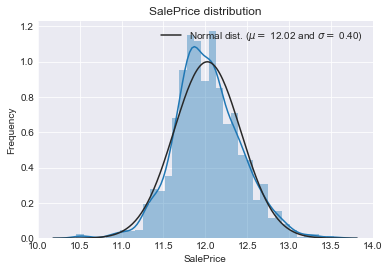

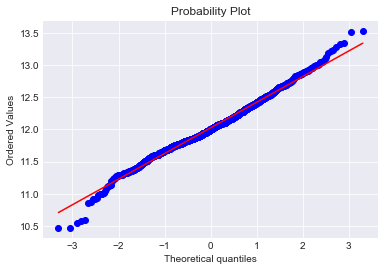

In [12]:
# Log-transformation of the target variable
# we use numpy log1p which applies log(1+x) to all the elements of Coloumn

train['SalePrice']=np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'],fit=norm)

mu,sigma=norm.fit(train['SalePrice'])
print('\n mu {:.2f} and sigma {:.2f} is '.format(mu,sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)], loc='best')

plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


# Feature Enginerring

In [13]:
# concatenate the train and test data in the same dataframe

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)

all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


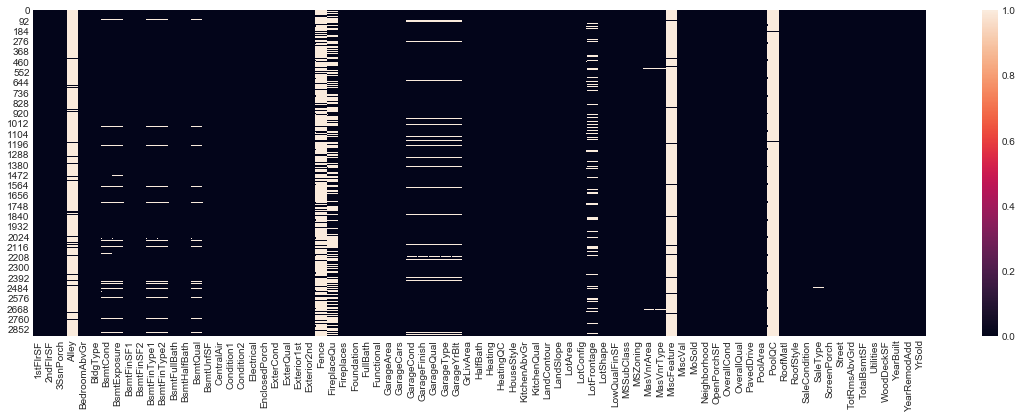

In [14]:
# Missing Data
plt.figure(figsize=(20,6))
sns.heatmap(all_data.isnull())

In [15]:
all_data_na=(all_data.isnull().sum() / len(all_data)) * 100
all_data_na=all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:34]

missing_data=pd.DataFrame(all_data_na,columns=['Missing Perc.'])
missing_data.sort_values(by='Missing Perc.',ascending=False,inplace=True)
missing_data.head(20)

,Missing Perc.
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageYrBlt,5.450806
GarageFinish,5.450806
GarageCond,5.450806
GarageQual,5.450806


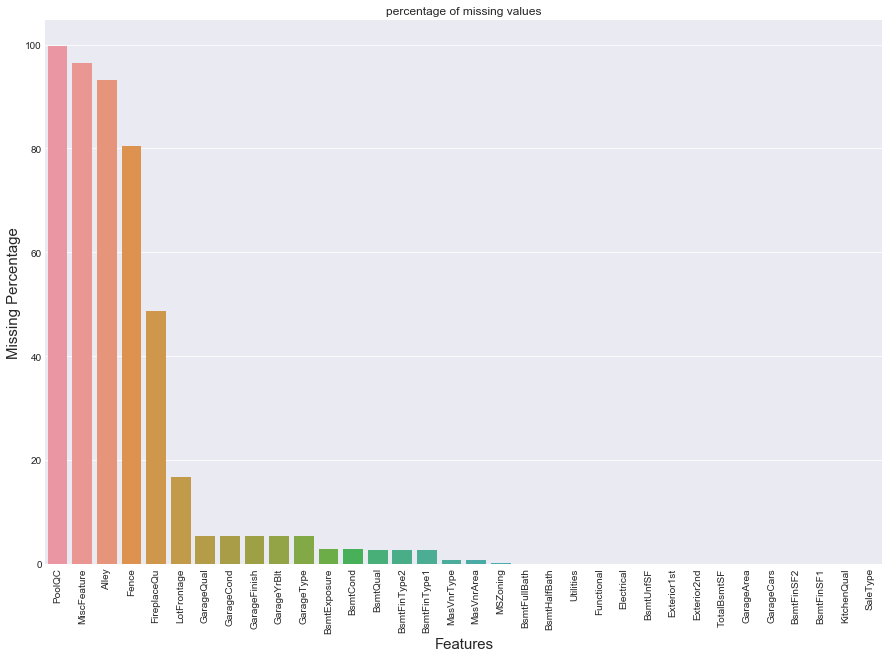

In [16]:
plt.figure(figsize=(15,10))
sns.barplot(x=all_data_na.index,y=missing_data['Missing Perc.'])
plt.xticks(rotation='90')
plt.xlabel('Features',fontsize=15)
plt.ylabel('Missing Percentage',fontsize=15)
plt.title('percentage of missing values')
plt.show()

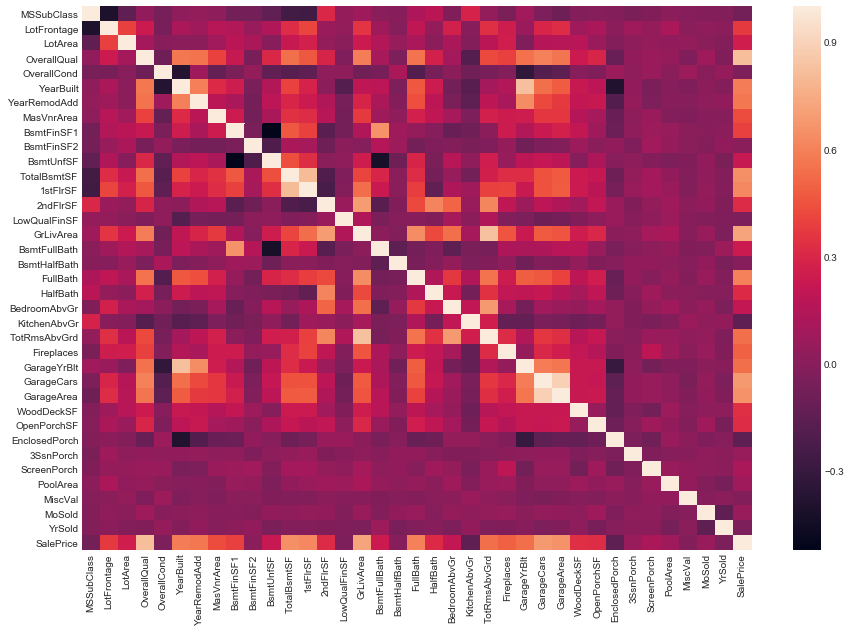

In [17]:
# correlation
corrmat=train.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrmat)

plt.show()

# Imputing missing values


1 PoolQC : data descryption has 99% NAN values which makes sense that majority of the houses has NO pool. 

In [18]:
all_data['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [19]:
all_data['PoolQC']=all_data['PoolQC'].fillna('None')

2 MiscFeatures : data descryption nan mean no misc features.

In [20]:
all_data['MiscFeature']=all_data['MiscFeature'].fillna('None')

3 Alley : data description says NA means "no alley access"

In [21]:
all_data["Alley"] = all_data["Alley"].fillna("None")

4 Fence : data description says NA means "no fence"

In [22]:
all_data["Fence"] = all_data["Fence"].fillna("None")

5 FireplaceQu : data description says NA means "no fireplace"

In [23]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

6 LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood ,we can fill in missing values by the median LotFrontage of the neighborhood.

In [24]:
all_data["LotFrontage"]=all_data.groupby("Neighborhood")['LotFrontage'].apply(lambda x: x.fillna(x.median()))

7 **GarageType, GarageFinish, GarageQual and GarageCond **: Replacing missing data with None

In [25]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

8 **GarageYrBlt, GarageArea and GarageCars **: Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [26]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

9 **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [27]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

10 **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement

In [28]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

11 **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area 
    and None for the type.

In [29]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

12 **MSZoning (The general zoning classification)** : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [30]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [31]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

13 **Utilities** : For this feature all records are "AllPub", except for one "NoSeWa".So,this will not be helping us in our prediction. We remove it 

In [32]:
all_data = all_data.drop(['Utilities'], axis=1)

14 **Functional**: we fill missing values with most common value typical.

In [33]:
all_data['Functional'].value_counts()

Typ     2715
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

In [34]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

15 **Electrical ** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [35]:
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

16 **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.

In [36]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')

17 **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [37]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

18 **SaleType ** : Fill in again with most frequent which is "WD"

In [38]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

19 **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [39]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [40]:
# checking for any missing value
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [41]:
# transforming some numerical values that are really categorial

In [42]:
# MSSubClass=The building class
all_data['MSSubClass']=all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond']=all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features.
all_data['YrSold']=all_data['YrSold'].apply(str)
all_data['YrSold']=all_data['YrSold'].apply(str)

In [43]:
# Applying label encoder to categorial values

from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbt=LabelEncoder()
    lbt.fit(list(all_data[c].values))
    lbt.transform(list(all_data[c].values))
    
print('Shape all_data: {}'.format(all_data.shape))
    


Shape all_data: (2917, 78)


# adding more features
 since area of the house is very important to determine the price of house.So, we add one more feature which 
 is the totalarea of the house by combining basement, first and second floor areas of each house.

In [44]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [45]:
# skewed Features
# or normally distributed data, the skewness should be about 0. A skewness value > 0 means that 
# there is more weight in the left tail of the distribution

In [46]:
numeric_feats= all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


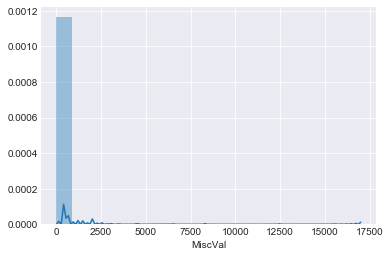

In [47]:
sns.distplot(all_data['MiscVal'],bins=20)

# Box Cox Transformation of (highly) skewed features

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .

Note that setting  λ=0  is equivalent to log1p used above for the target variable.

In [48]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 34 skewed numerical features to Box Cox transform


Getting dummies categorial variables

In [49]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 327)


In [50]:
# getting new training and testing sets
train = all_data[:ntrain]
test = all_data[ntrain:]


# Modelling

In [51]:
from sklearn.linear_model import ElasticNet, Lasso , BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge #combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler #Scale features using statistics that are robust to outliers
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb # LightGBM is a gradient boosting framework that uses tree based learning algorithms.faster and high accuracy

In [52]:
# defining cross validation 
# we used cross_val_score of sklearn however it does not have shuffle attribute So, we write a bit of code for that

In [53]:
# validation function
n_folds=5

def rmsle_cv(model):
    kf=KFold(n_splits=n_folds,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse=np.sqrt(-cross_val_score(model,X=train.values,y=y_train,scoring="neg_mean_squared_error",cv=kf))
    return rmse
    

# Lasso Regression
This model is very sensitive to outliers.So, we use RobustScaler() first in pipeline

In [54]:
lasso=make_pipeline( RobustScaler() , Lasso(alpha=0.0005, random_state=1))

# ElasticNet 
again RobustScaler() is used

In [55]:
ENet = make_pipeline( RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.9 ,random_state=3))

# KernalRidge Regressor

In [56]:
KRR = KernelRidge(alpha=0.6 , kernel='polynomial', degree=2, coef0=2.5)

# GradientBoosting Regressor
With **'huber' ** loss it is robust to outliers

In [57]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# Xgboost

In [58]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

# Lightweight GBM

In [1]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

NameError: name 'lgb' is not defined

Let us see how the base models performs in cross_validation scores RMSE

In [60]:
score= rmsle_cv(lasso)
print(score)
print("\nLasso score mean {:.4f} and Std {:.4f}".format(score.mean(),score.std()))

[0.10388069 0.11295382 0.12224113 0.10422789 0.11213132]

Lasso score mean 0.1111 and Std 0.0068


In [61]:
score= rmsle_cv(ENet)
print(score)
print("\nElasticNet score mean {:.4f} and Std {:.4f}".format(score.mean(),score.std()))

[0.10391973 0.11268511 0.12238785 0.1041026  0.11215537]

ElasticNet score mean 0.1111 and Std 0.0068


In [62]:
score= rmsle_cv(KRR)
print(score)
print("\nkernalRigdeRegessor score mean {:.4f} and Std {:.4f}".format(score.mean(),score.std()))

[0.11100013 0.12031231 0.12278816 0.1084419  0.11267769]

kernalRigdeRegessor score mean 0.1150 and Std 0.0055


In [63]:
score= rmsle_cv(GBoost)
print(score)
print("\nGradientBoosting score mean {:.4f} and Std {:.4f}".format(score.mean(),score.std()))

[0.10912885 0.12606519 0.12238605 0.10496254 0.11235921]

GradientBoosting score mean 0.1150 and Std 0.0080


In [64]:
score= rmsle_cv(model_xgb)
print(score)
print("\nLightweightGradientBoosting score mean {:.4f} and Std {:.4f}".format(score.mean(),score.std()))

[0.11459567 0.11928251 0.12052531 0.10963203 0.12145565]

LightweightGradientBoosting score mean 0.1171 and Std 0.0044


In [65]:
score= rmsle_cv(model_lgb)
print(score)
print("\nLightweightGradientBoosting score mean {:.4f} and Std {:.4f}".format(score.mean(),score.std()))

[0.11085981 0.1234559  0.12874653 0.10744768 0.11687404]

LightweightGradientBoosting score mean 0.1175 and Std 0.0078


# Stacking Models


 **simple stacking approach : Averaging the base models **
We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse inheritance

In [66]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,models):
        self.models=models
        
    # we define the clone of the original model to fit the data in
    def fit(self, X, y):
        self.models_=[clone(x) for x in self.models]
        
        # train the base models
        for model in self.models_:
            model.fit(X,y)
            
        return self
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([ model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)   

In [67]:
# We just average four models here ENet, GBoost, KRR and lasso.
averaging_models=AveragingModels(models=( ENet, GBoost, KRR, lasso) )

score=rmsle_cv(averaging_models)
print("\naveraging_models score mean {:.4f} and Std {:.4f}".format(score.mean(),score.std()))


averaging_models score mean 0.1086 and Std 0.0065


# Adding meta model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

1) Split the total training set into two disjoint sets (here train and .holdout )

2) Train several base models on the first part (train)

3) Test these base models on the second part (holdout)

4) Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

In [83]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models ,meta_model,n_folds=5):
        self.base_models=base_models
        self.meta_model=meta_model
        self.n_folds=n_folds
    
    # we again fit the data on the clone of the original models
    def fit(self,X,y):
        self.base_models_= [list() for x in self.base_models]
        self.meta_model_=clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds ,shuffle=True,random_state=158)
        
        # train cloned base model and create out of fold predictions
        # which are used to train meta_model
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        
        for i , model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance=clone(model)
                self.base_models_[i].append(instance)
                instance.fit( X[train_index] ,y[train_index] )
                y_pred= instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index,i]=y_pred
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) 
                                         for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
                
                
                
        
    

In [84]:
# stacking average model score
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1089 (0.0070)


we get a better score by adding meta leaners

# Ensembling StackedRegressor, XGBoost and LightGBM
We add XGBoost and LightGBM to the averagemodels.

In [89]:
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))
    

In [90]:
# final training and predictions

In [91]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08141826589364227


In [92]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.08201871697124351


In [93]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07316170100763152


In [94]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07832874875907438


In [95]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [96]:
result=pd.DataFrame()
result['Id']=test_id
result['SalePrice']=ensemble
result.to_csv('submission.csv',index=False)